In [61]:
from statsbombpy import sb
import pandas as pd

In [62]:
#find ids for bayer matches
matches = sb.matches(competition_id=9, season_id=281)
match_ids = matches['match_id'].values.tolist()

/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [63]:
#All events sorted for bayer home games and possession 
events = sb.competition_events(
    country="Germany",
    division= "1. Bundesliga",
    season="2023/2024",
    gender="male"
)
events = events[events['match_id'].isin(match_ids)]
df = events[events["team"]=="Bayer Leverkusen"]
df = df[df["possession_team"]=="Bayer Leverkusen"]


/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warning

In [64]:
#filter threshold for Xg:
df_xg = df[~df['shot_statsbomb_xg'].between(0, 0.05)]


In [65]:
#Events sorted in a specific order so each passing sequence is correctly sorted
sequences_sorted = df_xg.sort_values(['match_id', 'period','timestamp'], ascending=[True, True, True])


In [66]:
#make new ids because right now there is ids from 1 to x for each match but it repeats from 1 and up in every match so each possession id points to different matches 
# - i just put the possession id after match_id in the newly created id
sequences_sorted['possession_id'] = sequences_sorted['match_id'].astype(str) + sequences_sorted['possession'].astype(str)
sequences_sorted['possession_id'] = sequences_sorted['possession_id'].astype(int)
sequences_sorted

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,...,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,possession_id
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"{'formation': 343, 'lineup': [{'player': {'id'...",Bayer Leverkusen,904,00:00:00.000,Starting XI,NaN,38950521
200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:00:00.000,Half Start,NaN,38950521
38367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:01:52.588,Pass,NaN,38950526
38368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:01:53.452,Pass,NaN,38950526
76642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:01:53.452,Ball Receipt*,NaN,38950526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:46:19.464,Pass,True,3895348131
44632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:46:20.444,Ball Receipt*,NaN,3895348131
82227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[71.9, 6.3]",NaN,...,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:46:20.444,Carry,True,3895348131
5584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:46:21.205,Pass,True,3895348131


In [67]:
#get the ids of sequences which contain a shot (contain an xg value)
shot_sequences = sequences_sorted[sequences_sorted["shot_statsbomb_xg"].notna()]
shot_sequences_ids = shot_sequences["possession_id"].unique()

In [68]:
#filter for possession sequences which end with a shot
sequences_filtered = sequences_sorted[sequences_sorted['possession_id'].isin(shot_sequences_ids)]

In [69]:
#fill all rows with an xg for the corresponding sequence - right now there are many missing values in "shot_statsbomb_xg"
sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
# sort by possession id and order by timestamp


/var/folders/dl/s9k442mn7m1077_4b28hhf6c0000gn/T/ipykernel_21045/88506660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))


In [70]:
#make end location for passes and carries (start location has no missing values)
#combine the two types (pass and carry) into one location column (now we dont know if an edge is a pass or carry btw)
sequences_filtered['end_location'] = sequences_filtered['location'].shift(-1)

/var/folders/dl/s9k442mn7m1077_4b28hhf6c0000gn/T/ipykernel_21045/1044016736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_filtered['end_location'] = sequences_filtered['location'].shift(-1)


In [71]:
#now we dont need the shot event rows any more so remove them
sequences_filtered = sequences_filtered[sequences_filtered["type"]!="Shot"]

In [72]:
#assign x and y coordinates from location lists
sequences_filtered["start_x"] = sequences_filtered["location"].str[0]
sequences_filtered["start_y"] = sequences_filtered["location"].str[1]
sequences_filtered["end_x"] = sequences_filtered["end_location"].str[0]
sequences_filtered["end_y"] = sequences_filtered["end_location"].str[1]

In [73]:
#reduce the number of possible x and y coordinates, essentially making the fields/nodes of the pitch larger
sequences_filtered['start_node_x'] = round(sequences_filtered['start_x'] / 20)
sequences_filtered['start_node_y'] = round(sequences_filtered['start_y'] / 20)
sequences_filtered['end_node_x'] = round(sequences_filtered['end_x'] / 20)
sequences_filtered['end_node_y'] = round(sequences_filtered['end_y'] / 20)

In [74]:
#invert y values in second period
sequences_filtered_p1 = sequences_filtered[sequences_filtered["period"]==1]
sequences_filtered_p2 = sequences_filtered[sequences_filtered["period"]==2]
sequences_filtered_p2["start_node_y"] = 4 - sequences_filtered_p2["start_node_y"] 
sequences_filtered_p2["end_node_y"] = 4 - sequences_filtered_p2["end_node_y"] 

/var/folders/dl/s9k442mn7m1077_4b28hhf6c0000gn/T/ipykernel_21045/2810762259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_filtered_p2["start_node_y"] = 4 - sequences_filtered_p2["start_node_y"]
/var/folders/dl/s9k442mn7m1077_4b28hhf6c0000gn/T/ipykernel_21045/2810762259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_filtered_p2["end_node_y"] = 4 - sequences_filtered_p2["end_node_y"]


In [75]:
#concatenate the two period dataframes
sequences_filtered = pd.concat([sequences_filtered_p1,sequences_filtered_p2], axis=0, ignore_index=True)

In [76]:
#combine the x and y coordinates
sequences_filtered["start_node"] = sequences_filtered["start_node_x"] + sequences_filtered["start_node_y"] / 10
sequences_filtered["end_node"] = sequences_filtered["end_node_x"] + sequences_filtered["end_node_y"] / 10

In [87]:
#sort to desired columns
sequences_filtered['time'] = sequences_filtered['minute'] *60 + sequences_filtered['second']
sequences_filtered = sequences_filtered.sort_values(['possession_id', 'timestamp'], ascending=[True, True])

sequences_filtered = sequences_filtered[sequences_filtered['start_node'] != sequences_filtered['end_node']]
sequences_filtered['sequence'] = sequences_filtered.groupby('possession_id').cumcount(ascending=False) + 1

example = sequences_filtered[["start_node","end_node","xg","possession_id","sequence","minute","second",'timestamp']]
example = example.sort_values(['possession_id','sequence'], ascending=[True, True])


In [89]:
example[example['possession_id'] == 38952108]


,start_node,end_node,xg,possession_id,sequence,minute,second,timestamp
2512,5.2,6.0,0.051985,38952108,1,8,5,00:08:05.875
2511,5.3,5.2,0.051985,38952108,2,8,4,00:08:04.725
2505,4.3,5.3,0.051985,38952108,3,8,1,00:08:01.239
2502,5.3,4.3,0.051985,38952108,4,7,59,00:07:59.770
2497,4.3,5.3,0.051985,38952108,5,7,56,00:07:56.641
2486,5.3,4.3,0.051985,38952108,6,7,51,00:07:51.465
2480,4.3,5.3,0.051985,38952108,7,7,45,00:07:45.068
2478,5.3,4.3,0.051985,38952108,8,7,43,00:07:43.125
2477,4.3,5.3,0.051985,38952108,9,7,42,00:07:42.671
2474,5.3,4.3,0.051985,38952108,10,7,41,00:07:41.269


In [22]:
#remove edges between the same node if wanted
final_sequences = sequences_filtered[sequences_filtered['start_node'] != sequences_filtered['end_node']]

In [23]:
#remove rows with missing values - there are only a few
final_sequences.dropna(inplace=True)

/var/folders/dl/s9k442mn7m1077_4b28hhf6c0000gn/T/ipykernel_16930/309154560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sequences.dropna(inplace=True)


In [24]:
#remove sequences with few passes if wanted
index_counts = final_sequences['possession_id'].value_counts()
final_sequences = final_sequences[final_sequences['possession_id'].isin(index_counts[index_counts > 5].index)]

In [76]:
#get all the unique possession ids for iteration
possession_index = final_sequences["possession_id"].unique()

In [77]:
import networkx as nx

#iterate over possession ids and each row and append edges to a list for each graph and append that graph to a graphs dictionary (directed graph created with "nx.DiGraph(edges)")
#xg added as an attribute for each graph
graphs_dict = {}
for j in possession_index:
    edges = []
    for i in final_sequences.index:
        if j == final_sequences["possession_id"][i]:
            edges.append((final_sequences["start_node"][i], final_sequences["end_node"][i]))
            if j not in graphs_dict:
                graphs_dict[j] = {"xg": final_sequences["xg"][i], "graph": None}
            else:
                graphs_dict[j]["xg"] = final_sequences["xg"][i]
                
    graph = nx.DiGraph(edges)
    graphs_dict[j]["graph"] = graph

graph_list = [value["graph"] for value in graphs_dict.values()]

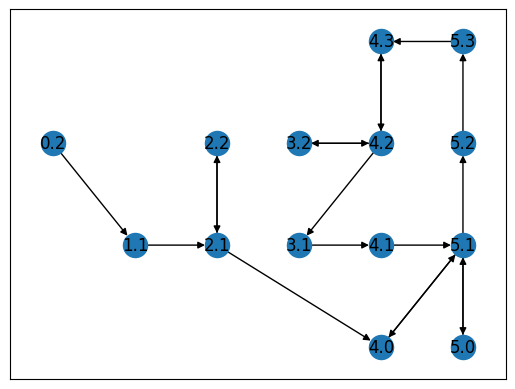

In [81]:
import matplotlib.pyplot as plt
import networkx as nx

game_pos = 3895348127
# Extract positions from numeric node labels
positions = {}
for node in graphs_dict[game_pos]["graph"].nodes():
    # Convert the node to a string first, then split by the decimal
    x = int(node)  # Integer part represents the x position
    y = node - x   # Decimal part represents the y position
    positions[node] = (x, y)

# Draw the graph using the positions
nx.draw_networkx(graphs_dict[game_pos]["graph"], pos=positions)

# Show the plot
plt.show()
